In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.optimize as sco

### Part 1

In [2]:
mu = np.array([0.02, 0.07, 0.15, 0.2]).reshape(4,1)
sigma = np.array([0.05, 0.12, 0.17, 0.25]).reshape(4,1)
R = np.array([1, 0.3, 0.3, 0.3, 
              0.3, 1, 0.6, 0.6, 
              0.3, 0.6, 1, 0.6, 
              0.3, 0.6, 0.6, 1]).reshape(4,4)

In [3]:
def compute_tangent_portfolio(mu, sigma, R, r):

    S = np.diag(sigma.reshape(4,))
    Sigma = np.linalg.multi_dot([S, R, S])

    A = np.linalg.multi_dot([np.array([1,1,1,1]), np.linalg.inv(Sigma), np.array([[1],[1],[1],[1]])])
    B = np.linalg.multi_dot([mu.T, np.linalg.inv(Sigma), np.array([[1],[1],[1],[1]])])
    C = np.linalg.multi_dot([mu.T, np.linalg.inv(Sigma), mu])

    omega_t = np.dot(np.linalg.inv(Sigma), (mu-r*np.array([[1],[1],[1],[1]]))) / (B - A*r)
    assert round(omega_t.sum(),2) == 1.0
    
    sigma_t = np.sqrt(np.linalg.multi_dot([omega_t.T, Sigma, omega_t]))[0][0]
    m_t = np.dot(omega_t.T, mu)[0][0]
    
    weights = {f"W_{i}": round(w* 100, 4) for i, w in enumerate(omega_t.reshape(4,))}
    print(f'Portfolio Weights {weights}')
    print(f'Portfolio Risk {sigma_t*100}%')
    print(f'Portfolio Returns {m_t*100}%')

    return omega_t, sigma_t, m_t

In [4]:
weights_50, risk_50, ret_50 = compute_tangent_portfolio(mu, sigma, R, 0.005)

Portfolio Weights {'W_0': 1.6835, 'W_1': -22.9367, 'W_2': 81.434, 'W_3': 39.8192}
Portfolio Risk 19.65106415308288%
Portfolio Returns 18.607035820176367%


In [5]:
weights_100, risk_100, ret_100 = compute_tangent_portfolio(mu, sigma, R, 0.01)

Portfolio Weights {'W_0': -74.5937, 'W_1': -51.0569, 'W_2': 149.0249, 'W_3': 76.6257}
Portfolio Risk 35.066537014279426%
Portfolio Returns 32.61302309882414%


In [6]:
weights_150, risk_150, ret_150 = compute_tangent_portfolio(mu, sigma, R, 0.015)

Portfolio Weights {'W_0': -864.4854, 'W_1': -342.2571, 'W_2': 848.9651, 'W_3': 457.7774}
Portfolio Risk 197.23916979145127%
Portfolio Returns 177.65254343453137%


In [7]:
weights_175, risk_175, ret_175 = compute_tangent_portfolio(mu, sigma, R, 0.0175)

Portfolio Weights {'W_0': 810.3502, 'W_1': 275.1851, 'W_2': -635.1431, 'W_3': -350.3922}
Portfolio Risk 147.3514930236409%
Portfolio Returns -129.87994672869837%


### Part 2

In [8]:
initial_weights = np.array([0.25,0.25,0.25,0.25]).reshape(4,1)
bounds = tuple((-5, 5) for _ in range(4))

def portfolio_stats(weights):
    S = np.diag(sigma.reshape(4,))
    Sigma = np.linalg.multi_dot([S, R, S])
    returns = np.dot(weights.T, mu)[0]
    vols = np.sqrt(np.linalg.multi_dot([weights.T, Sigma, weights]))
    return returns, vols

def min_variance(weights):
    return portfolio_stats(weights)[1]**2

constraints=({'type': 'eq', 'fun': lambda x: sum(x) - 1})
result = sco.minimize(min_variance, initial_weights, method='SLSQP', 
                      bounds=bounds, constraints=constraints)

min_var_return , min_var_vol = portfolio_stats(result.x)

In [9]:
def min_volatility(weights):
    return portfolio_stats(weights)[1]

target_returns = np.linspace(min_var_return, 2.0, 1000)
vols = []

for target_return in target_returns:
    
    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_stats(x)[0] - target_return},
               {'type': 'eq', 'fun': lambda x: sum(x) - 1})
    
    optimsiation = sco.minimize(min_volatility, initial_weights, method='SLSQP', 
                                bounds=bounds, constraints=constraints)
    vols.append(optimsiation['fun'])

target_vols = np.array(vols)

efport = pd.DataFrame({
    'target_returns' : 100*target_returns,
    'target_vols': 100*target_vols,
})

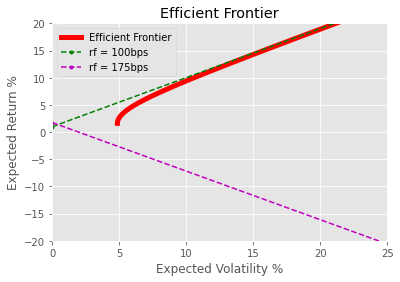

In [10]:
sns.lineplot(data=efport, x="target_vols", y="target_returns", color='red', linewidth = 5)
plt.plot([0, risk_100*100, risk_100*1000], [1.0, ret_100*100, ret_100*1000], 'g.--')
plt.plot([0, risk_175*100, risk_175*1000], [1.75, ret_175*100, ret_175*1000], 'm.--')
plt.xlabel("Expected Volatility %")
plt.ylabel("Expected Return %")
plt.title("Efficient Frontier")
plt.xlim([0, 25])
plt.ylim([-20, 20])
plt.legend(labels=['Efficient Frontier', 'rf = 100bps', 'rf = 175bps'])
plt.savefig("Question_2_plot.png", format='png')

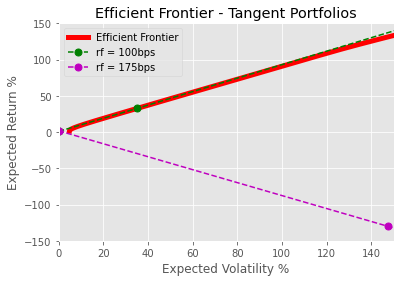

In [11]:

sns.lineplot(data=efport, x="target_vols", y="target_returns", color='red', linewidth = 5)
plt.plot([0, risk_100*100, risk_100*1000], [1.0, ret_100*100, ret_100*1000], 'g.--', markersize=14)
plt.plot([0, risk_175*100, risk_175*1000], [1.75, ret_175*100, ret_175*1000], 'm.--', markersize=14)
plt.xlabel("Expected Volatility %")
plt.ylabel("Expected Return %")
plt.title("Efficient Frontier - Tangent Portfolios")
plt.xlim([0, 150])
plt.ylim([-150, 150])
plt.legend(labels=['Efficient Frontier', 'rf = 100bps', 'rf = 175bps'])
plt.savefig("Question_2_plot_zoomed_out.png", format='png')